# Rossmann Store Sales Prediction

## Description
Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

---


# Data fields
Most of the fields are self-explanatory. The following are descriptions for those that aren't.

1. Id - an Id that represents a (Store, Date) duple within the test set
2. Store - a unique Id for each store
3. Sales - the turnover for any given day (this is what you are predicting)
4. Customers - the number of customers on a given day
5. Open - an indicator for whether the store was open: 0 = closed, 1 = open
6. StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
7. SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
8. StoreType - differentiates between 4 different store models: a, b, c, d
Assortment - describes an assortment level: a = basic, b = extra, c = extended
9. CompetitionDistance - distance in meters to the nearest competitor store
10. CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
11. Promo - indicates whether a store is running a promo on that day
12. Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
13. Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
14. PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [5]:
train_df = pd.read_csv('train.csv')
store_df = pd.read_csv('store.csv')
print("train_df: ", train_df.shape)
print("store_df: ", store_df.shape)

train_df:  (1017209, 9)
store_df:  (1115, 10)


# DATA PRE PROCESSING

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [8]:
train_df["Date"]=pd.to_datetime(train_df["Date"])
# Adding month day year columns
train_df["Day"]=train_df["Date"].dt.day
train_df["Month"]=train_df["Date"].dt.month
train_df["Year"]=train_df["Date"].dt.year

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 12 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
 9   Day            1017209 non-null  int32         
 10  Month          1017209 non-null  int32         
 11  Year           1017209 non-null  int32         
dtypes: datetime64[ns](1), int32(3), int64(7), object(1)
memory usage: 81.5+ MB


In [11]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


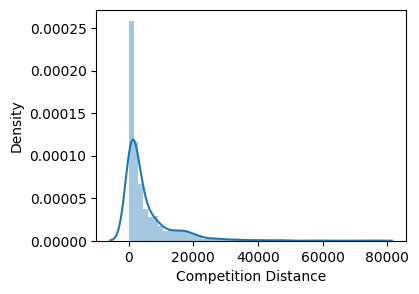

In [16]:
#plt.rcParams.update({'figure.figsize':(4,3),'figure.dpi':100})
sns.distplot(x=store_df['CompetitionDistance'], hist = True)
plt.xlabel('Competition Distance')
plt.show()

# Insights
Analysing nulls in store_df, CompetitionDistance contains less than 1% of missing data and its distribution is skewed towards the right and Median has resistance to outliers .

The categorical features Promo2SinceWeek Promo2SinceYear PromoInterval contain around 48.8% of missing data which is very high.

So we cant drop the rows we have drop the feature , If the features are important we can replace them with mode or make the missing value as different category.

CompetitionOpenSinceMonth, CompetitionOpenSinceYear this two features have around 31.78 % of missing values.

In [19]:
store_df["CompetitionDistance"]=store_df["CompetitionDistance"].fillna(store_df["CompetitionDistance"].median())

In [20]:
Colm_Miss=list()
for i in store_df.columns:
    if store_df[i].isnull().sum() > 0:
        print(i,":",store_df[i].isnull().sum()*100/len(store_df),"%")
        Colm_Miss.append(i)

CompetitionOpenSinceMonth : 31.748878923766817 %
CompetitionOpenSinceYear : 31.748878923766817 %
Promo2SinceWeek : 48.789237668161434 %
Promo2SinceYear : 48.789237668161434 %
PromoInterval : 48.789237668161434 %


In [22]:
Colm = set(store_df.columns)

Num_Colm= set(store_df._get_numeric_data())

Cat_Colm= Colm-Num_Colm

print("Categorical Columns are",Cat_Colm)

Categorical Columns are {'StoreType', 'Assortment', 'PromoInterval'}


In [25]:
for i in Colm_Miss:
  print('\033[91m' , i , '\033[0m')
  print(store_df[i].unique())

 CompetitionOpenSinceMonth 
[ 9. 11. 12.  4. 10.  8. nan  3.  6.  5.  1.  2.  7.]
 CompetitionOpenSinceYear 
[2008. 2007. 2006. 2009. 2015. 2013. 2014. 2000. 2011.   nan 2010. 2005.
 1999. 2003. 2012. 2004. 2002. 1961. 1995. 2001. 1990. 1994. 1900. 1998.]
 Promo2SinceWeek 
[nan 13. 14.  1. 45. 40. 26. 22.  5.  6. 10. 31. 37.  9. 39. 27. 18. 35.
 23. 48. 36. 50. 44. 49. 28.]
 Promo2SinceYear 
[  nan 2010. 2011. 2012. 2009. 2014. 2015. 2013.]
 PromoInterval 
[nan 'Jan,Apr,Jul,Oct' 'Feb,May,Aug,Nov' 'Mar,Jun,Sept,Dec']


In [26]:
for i in Colm_Miss:
  store_df[i].fillna(store_df[i].mode()[0], inplace = True)

In [27]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1115 non-null   float64
 4   CompetitionOpenSinceMonth  1115 non-null   float64
 5   CompetitionOpenSinceYear   1115 non-null   float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            1115 non-null   float64
 8   Promo2SinceYear            1115 non-null   float64
 9   PromoInterval              1115 non-null   object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


# Outlier treatment

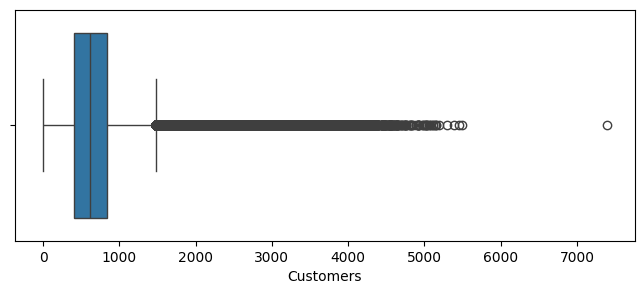

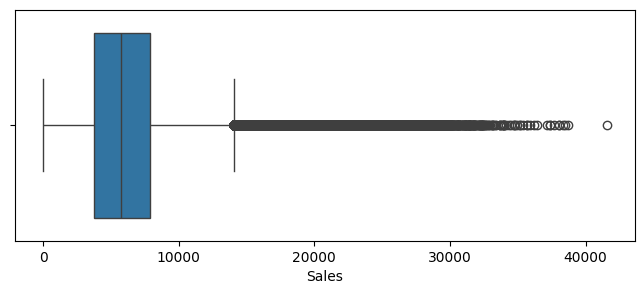

In [28]:
plt.rcParams.update({'figure.figsize':(8,3),'figure.dpi':100})


for i in list({"Customers","Sales"}):

  sns.boxplot(x=i,data=train_df)
  plt.show()

# Insights
As Increase in sales can cause by increse advertising ,offers and festivals etc . So sales and cutomers can be high seach case
We can reduce the effect of outliers by feature transformation

In [30]:
# Load dataset (update the path accordingly)


# Merge store data with training data
Sales = train_df.merge(store_df, on='Store', how='left')
print("Number of rows and columns for new dataframe is", Sales.shape)
# Display first few rows
Sales.head()


Number of rows and columns for new dataframe is (1017209, 21)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Day,...,Year,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,31,...,2015,c,a,1270.0,9.0,2008.0,0,14.0,2011.0,"Jan,Apr,Jul,Oct"
1,2,5,2015-07-31,6064,625,1,1,0,1,31,...,2015,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,31,...,2015,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,31,...,2015,c,c,620.0,9.0,2009.0,0,14.0,2011.0,"Jan,Apr,Jul,Oct"
4,5,5,2015-07-31,4822,559,1,1,0,1,31,...,2015,a,a,29910.0,4.0,2015.0,0,14.0,2011.0,"Jan,Apr,Jul,Oct"


##  Univariated Analysis

In [31]:
for i in list(set(Sales.columns)-{"Store","Date","CompetitionDistance","Sales","Customers"}):
  print('\033[91m' , i , '\033[0m')
  print(Sales[i].unique())

 CompetitionOpenSinceMonth 
[ 9. 11. 12.  4. 10.  8.  3.  6.  5.  1.  2.  7.]
 Promo2SinceYear 
[2011. 2010. 2012. 2009. 2014. 2015. 2013.]
 PromoInterval 
['Jan,Apr,Jul,Oct' 'Feb,May,Aug,Nov' 'Mar,Jun,Sept,Dec']
 Month 
[ 7  6  5  4  3  2  1 12 11 10  9  8]
 DayOfWeek 
[5 4 3 2 1 7 6]
 StoreType 
['c' 'a' 'd' 'b']
 StateHoliday 
['0' 'a' 'b' 'c' 0]
 Promo2SinceWeek 
[14. 13.  1. 45. 40. 26. 22.  5.  6. 10. 31. 37.  9. 39. 27. 18. 35. 23.
 48. 36. 50. 44. 49. 28.]
 Year 
[2015 2014 2013]
 Open 
[1 0]
 Assortment 
['a' 'c' 'b']
 CompetitionOpenSinceYear 
[2008. 2007. 2006. 2009. 2015. 2013. 2014. 2000. 2011. 2010. 2005. 1999.
 2003. 2012. 2004. 2002. 1961. 1995. 2001. 1990. 1994. 1900. 1998.]
 Day 
[31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10  9  8
  7  6  5  4  3  2  1]
 SchoolHoliday 
[1 0]
 Promo2 
[0 1]
 Promo 
[1 0]


### At "StateHoliday" there were some entry of 0 as string and as integer so make them all integer

In [32]:
Sales["StateHoliday"] = Sales["StateHoliday"].replace("0",0)

### Exploratory Data Analysis

# Hypothesis
Promotion will leads to increse in sales

Weekend the sales would be low as stores will be closed

Holidays will leads to decrese in sales

The number of customers will positively correlated with sales

Sales will be zero when stores are closed

PromoInterval
Jan,Apr,Jul,Oct     801153
Feb,May,Aug,Nov     118596
Mar,Jun,Sept,Dec     97460
Name: count, dtype: int64


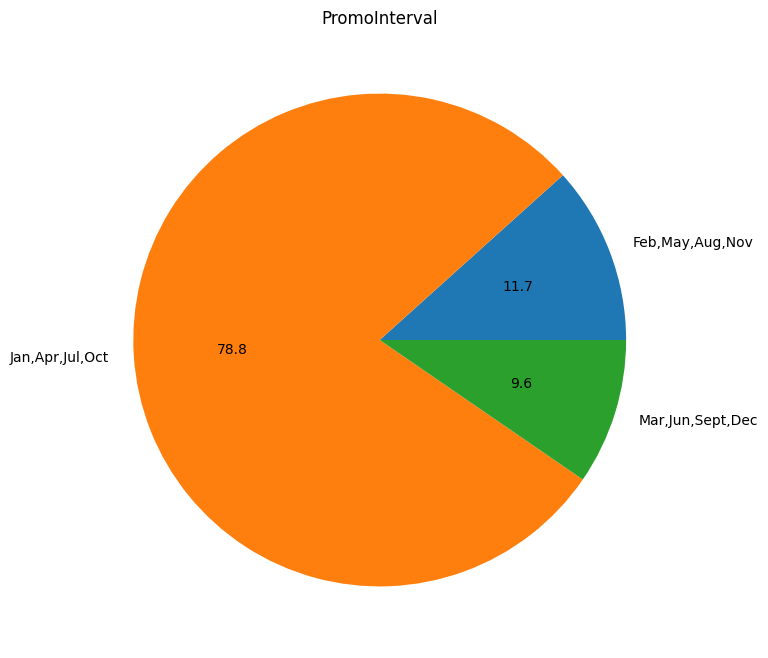

 =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  = 
Open
1    844392
0    172817
Name: count, dtype: int64


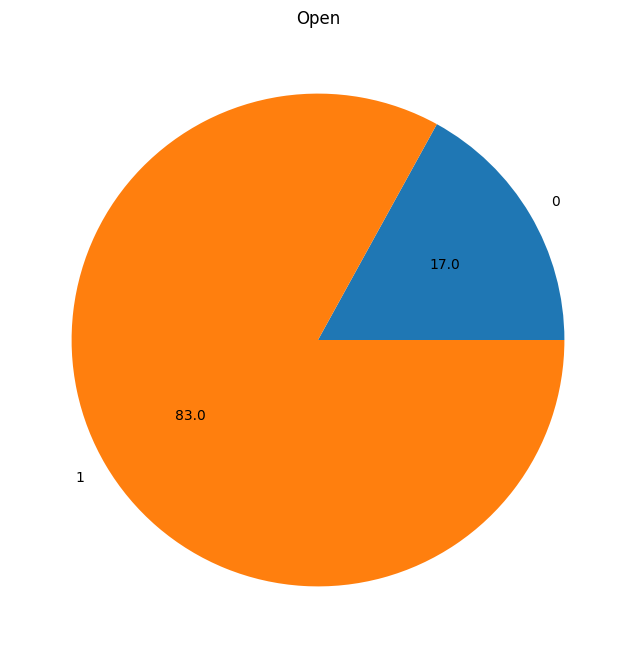

 =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  = 
Assortment
a    537445
c    471470
b      8294
Name: count, dtype: int64


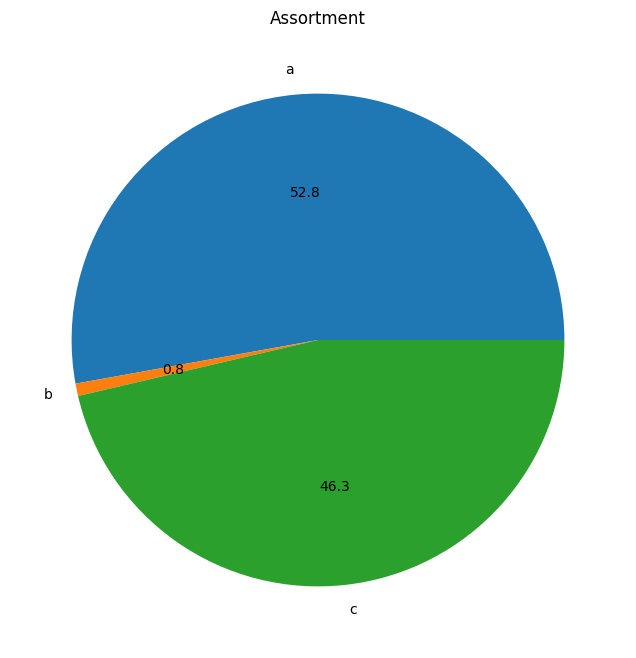

 =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  = 
SchoolHoliday
0    835488
1    181721
Name: count, dtype: int64


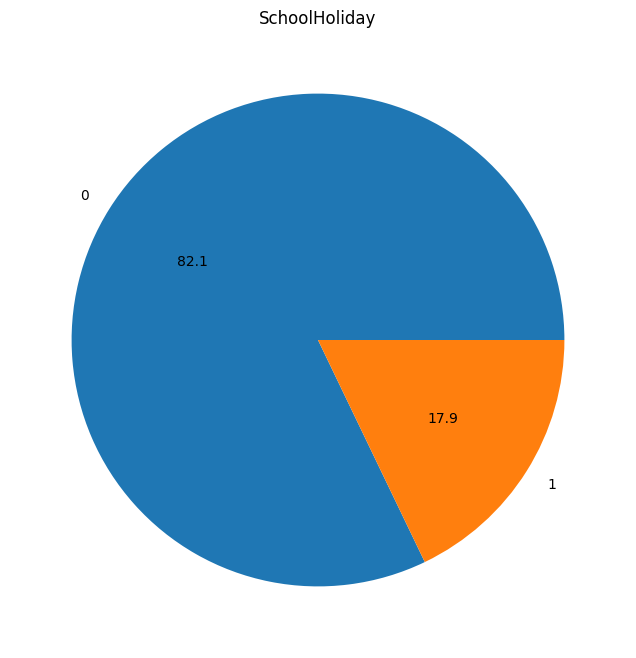

 =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  = 
Promo2
1    509178
0    508031
Name: count, dtype: int64


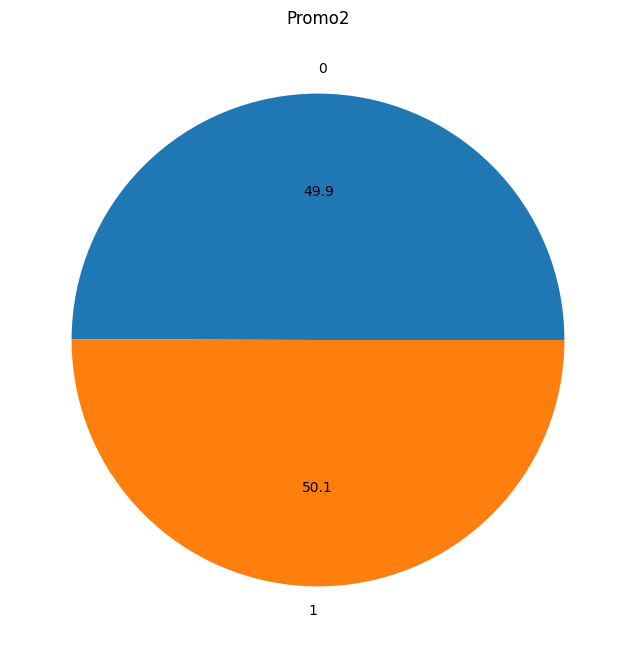

 =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  = 
Promo
0    629129
1    388080
Name: count, dtype: int64


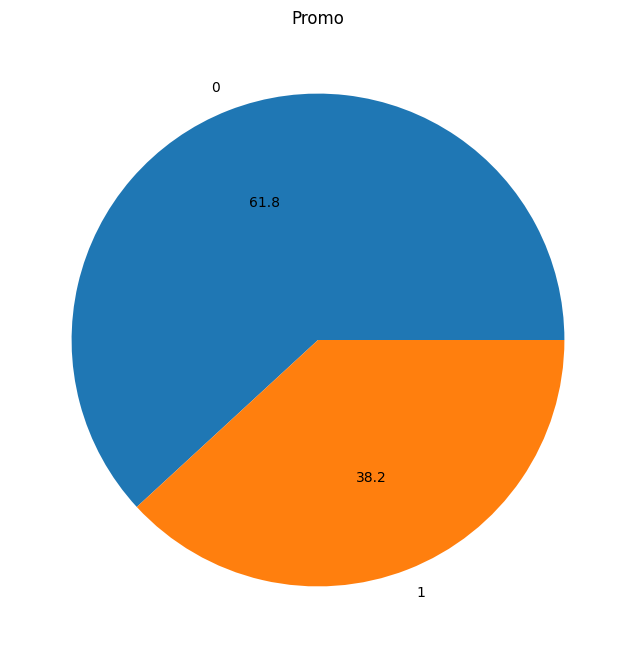

 =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  = 
Year
2013    406974
2014    373855
2015    236380
Name: count, dtype: int64


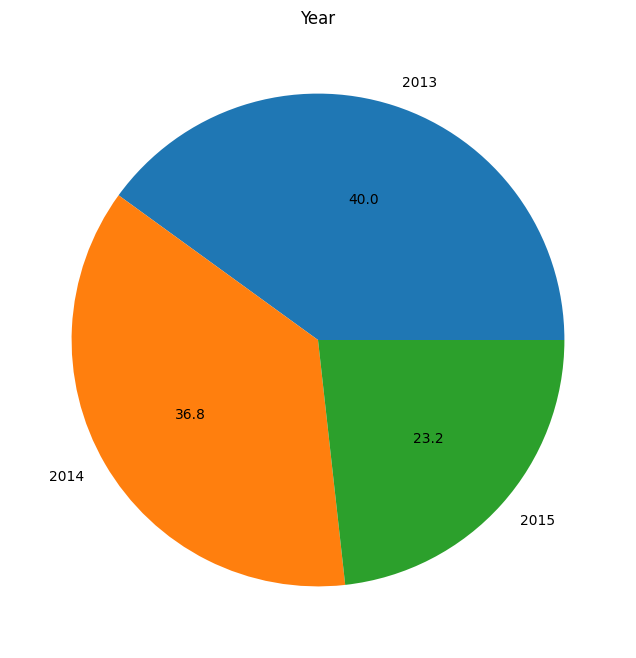

 =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  = 


In [33]:
for i in set(Sales.columns):
  if len(Sales[i].unique()) > 3:
    continue
  plt.rcParams.update({'figure.figsize':(8,8),'figure.dpi':100})
  Sales.groupby(i).size().plot(kind='pie',autopct='%.1f')
  print(Sales[i].value_counts())
  plt.title(i)

  plt.show()
  print("\033[91m = \033[0m" * 30)


# Insights
Most promo intervals are happening in Jan, Apr, Jul, Oct (78.8%).

17% data is of closed stores

38.2 % data has promotion involved

54.2% data is of store type "a"



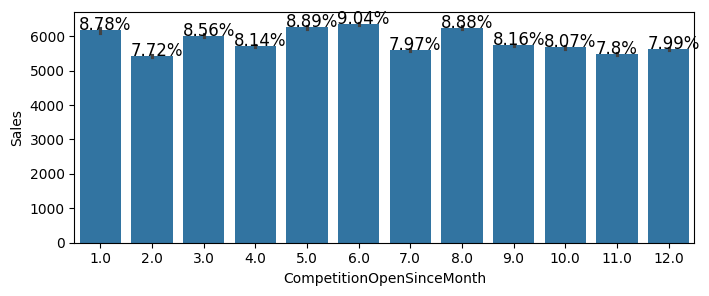

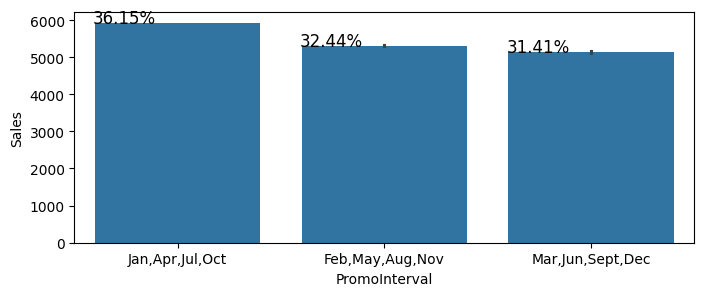

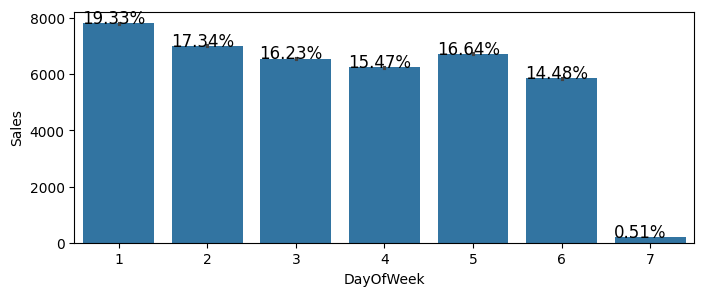

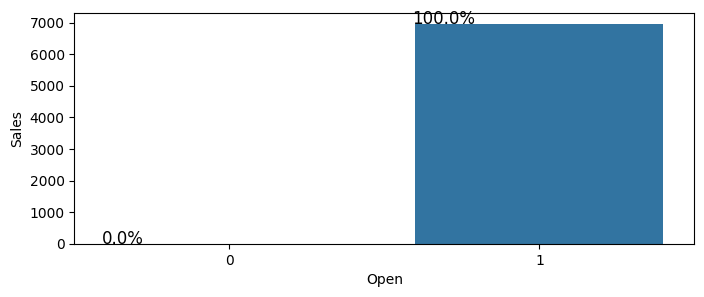

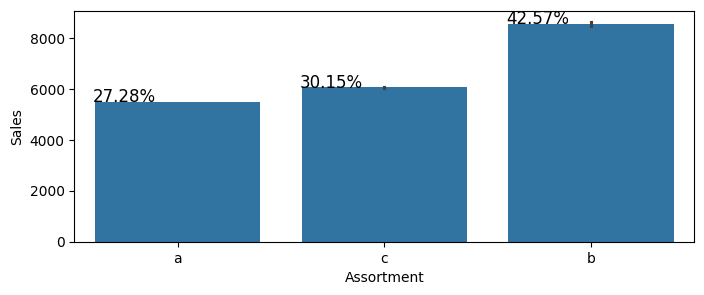

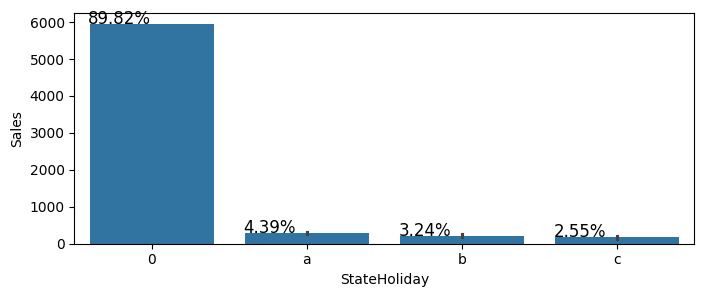

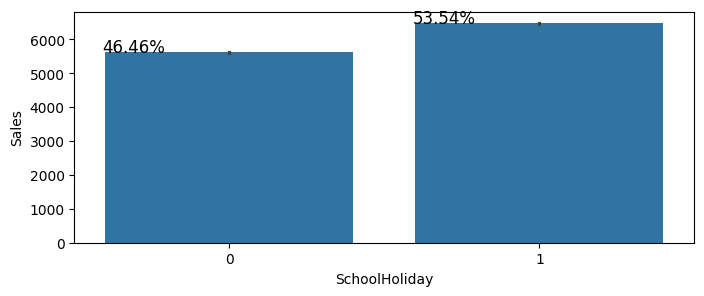

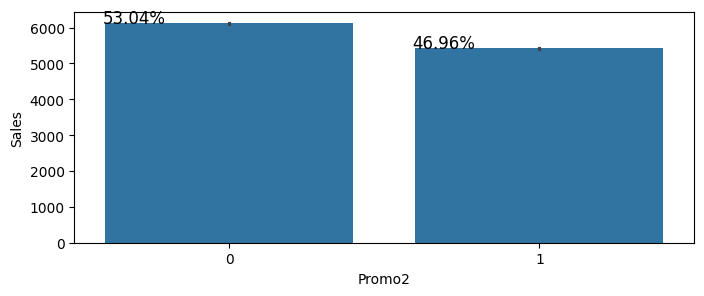

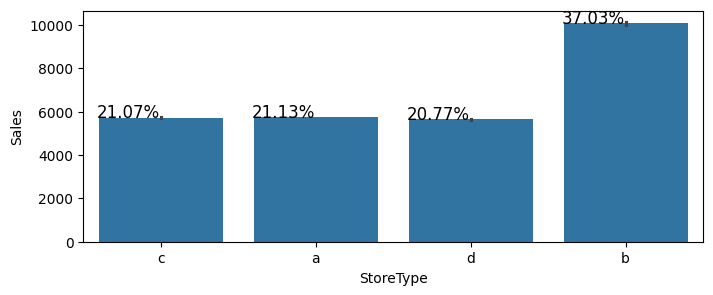

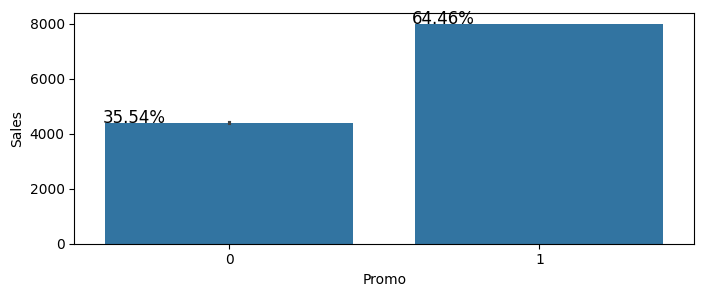

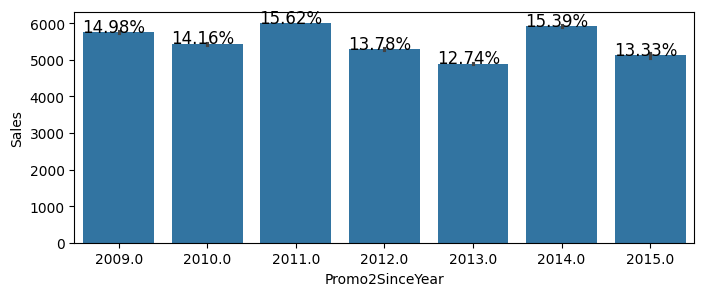

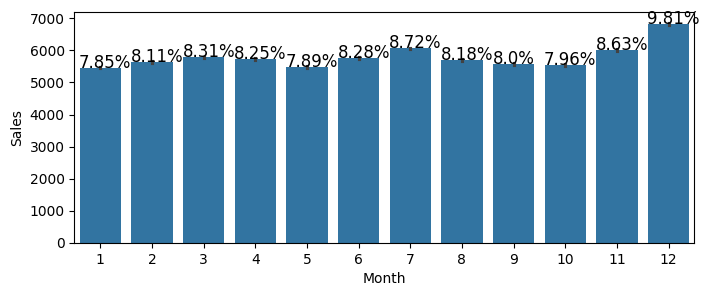

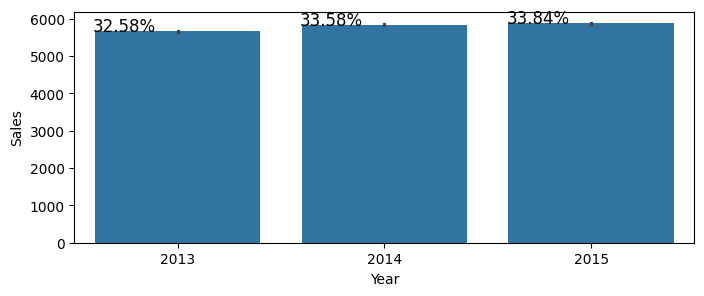

In [34]:
for i in set(Sales.columns):
  plt.rcParams.update({'figure.figsize':(8,3),'figure.dpi':100})
  #cant visualize large number of categories
  if len(Sales[i].unique()) > 15:
    continue
  ax = sns.barplot(x=Sales[i], y=Sales['Sales'])
  totals = []
  for i in ax.patches: #for every patch in the barplot ax
      totals.append(i.get_height()) #append height for each patch

  total = sum(totals) #sum of each patch height for a plot

  for i in ax.patches:
      ax.text(i.get_x() - .01, i.get_height() + .5, \
              str(round((i.get_height()/total)*100, 2))+'%', fontsize=12)  #text position and formula for percentage
  plt.show()


# Insights
Shopes are closed at sunday so the sales are lowest due to which the monday has slightly increase in sales

Normally many stores are closed on state holiday which leads to decrease in sales

On school holiday the sales are increased

Its obvious that the sales are when stores are open we have to remove data containing the store closed

Store type B has highest sales and promotion increases the sales.

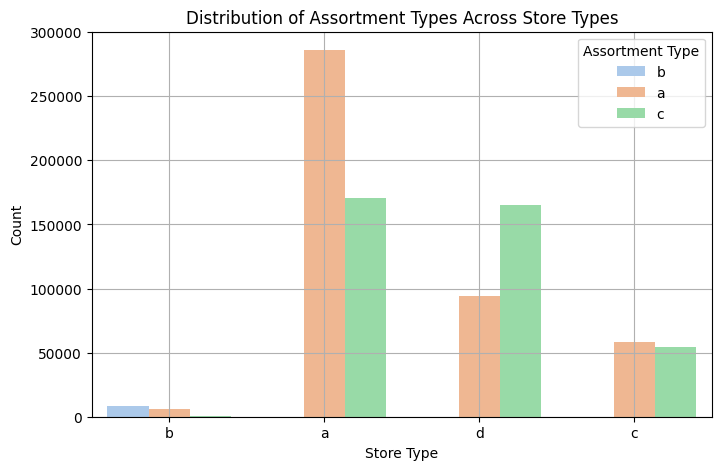

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.countplot(x='StoreType', hue='Assortment', data=Sales, palette='pastel')

plt.title("Distribution of Assortment Types Across Store Types")
plt.xlabel("Store Type")
plt.ylabel("Count")
plt.legend(title="Assortment Type")
plt.grid(True)
plt.show()


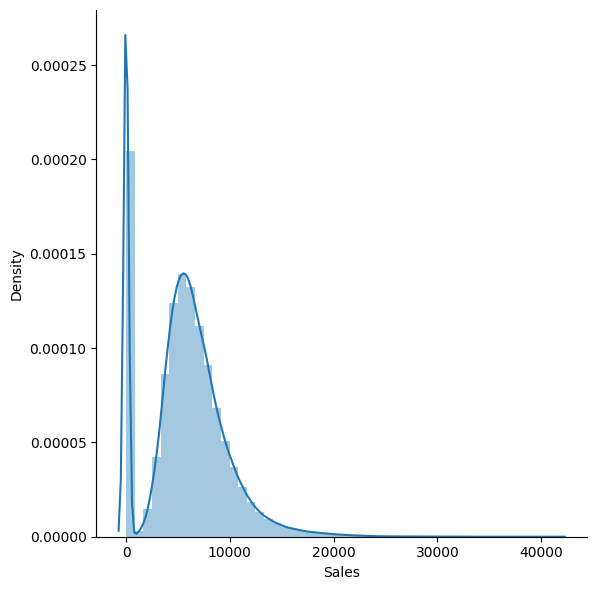

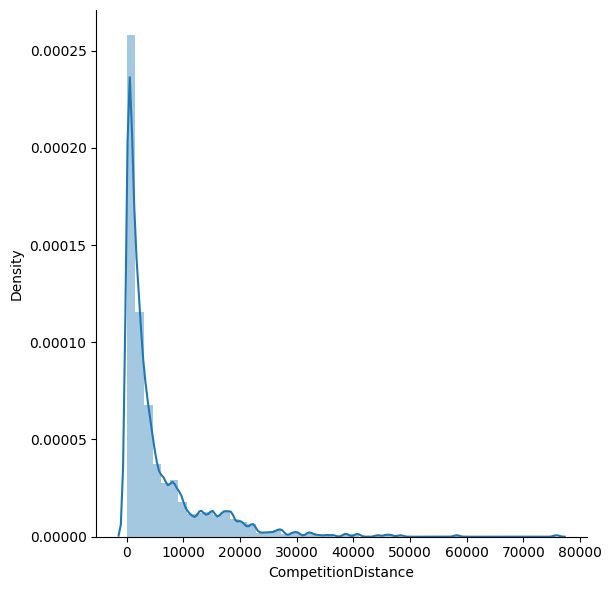

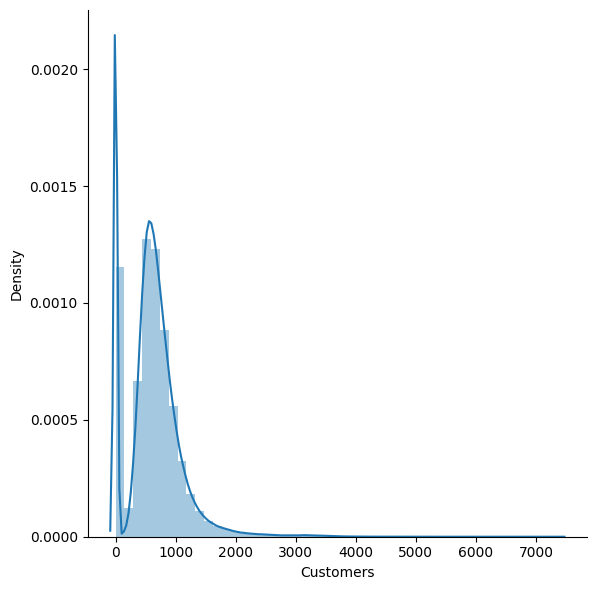

In [36]:
for i in ["Sales","CompetitionDistance",'Customers']:


  sns.FacetGrid(Sales,height=6)\
    .map(sns.distplot,i)\
    .add_legend();

  plt.show()


# Insights
The CompetitionDistance is right skewed so we have to try transformation on this features. 

Density of Sales at 0 is high this is because some stores in the dataset were temporarily closed for refurbishment .

# Multivariated Analysis

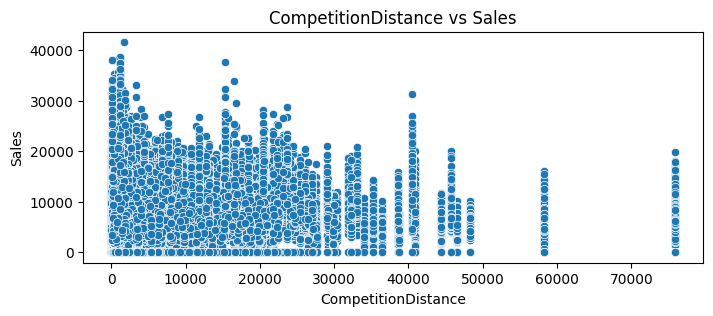

In [37]:
sns.scatterplot(data=Sales,x="CompetitionDistance",y="Sales")
plt.title("CompetitionDistance vs Sales")
plt.show()

In [89]:
Sales.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'Day', 'Month', 'Year', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

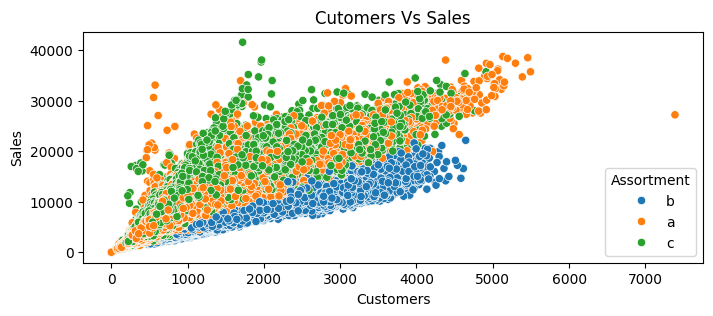

In [91]:
sns.scatterplot(data=Sales,x="Customers",y="Sales",hue='Assortment')
plt.title("Cutomers Vs Sales")
plt.show()

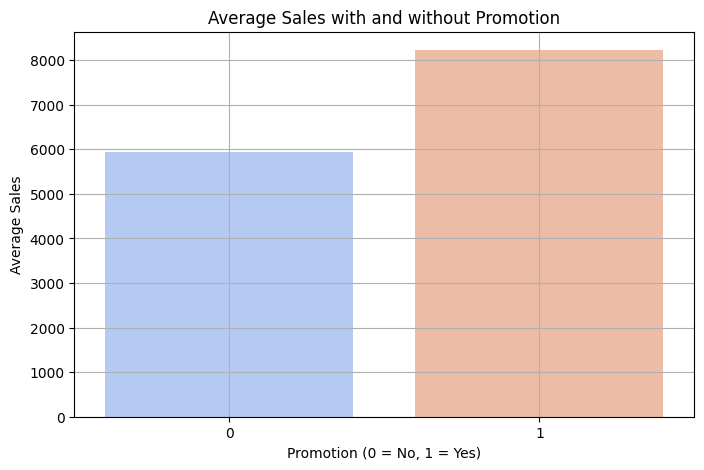

In [85]:
plt.figure(figsize=(8,5))
sns.barplot(x='Promo', y='Sales', data=Sales, ci=None, palette="coolwarm")
plt.title("Average Sales with and without Promotion")
plt.xlabel("Promotion (0 = No, 1 = Yes)")
plt.ylabel("Average Sales")
plt.grid(True)
plt.show()


# Insights
The competitor stores are closed to each other has more sales
We can see that sales are positively correlated with customers 

In [40]:
Sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 21 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  object        
 8   SchoolHoliday              1017209 non-null  int64         
 9   Day                        1017209 non-null  int32         
 10  Month                      1017209 non-null  int32         
 11  Year                       1017209 no

In [46]:
Num_Colm= list(Sales._get_numeric_data())
Num_Colm

['Store',
 'DayOfWeek',
 'Sales',
 'Customers',
 'Open',
 'Promo',
 'SchoolHoliday',
 'Day',
 'Month',
 'Year',
 'CompetitionDistance',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Promo2',
 'Promo2SinceWeek',
 'Promo2SinceYear']

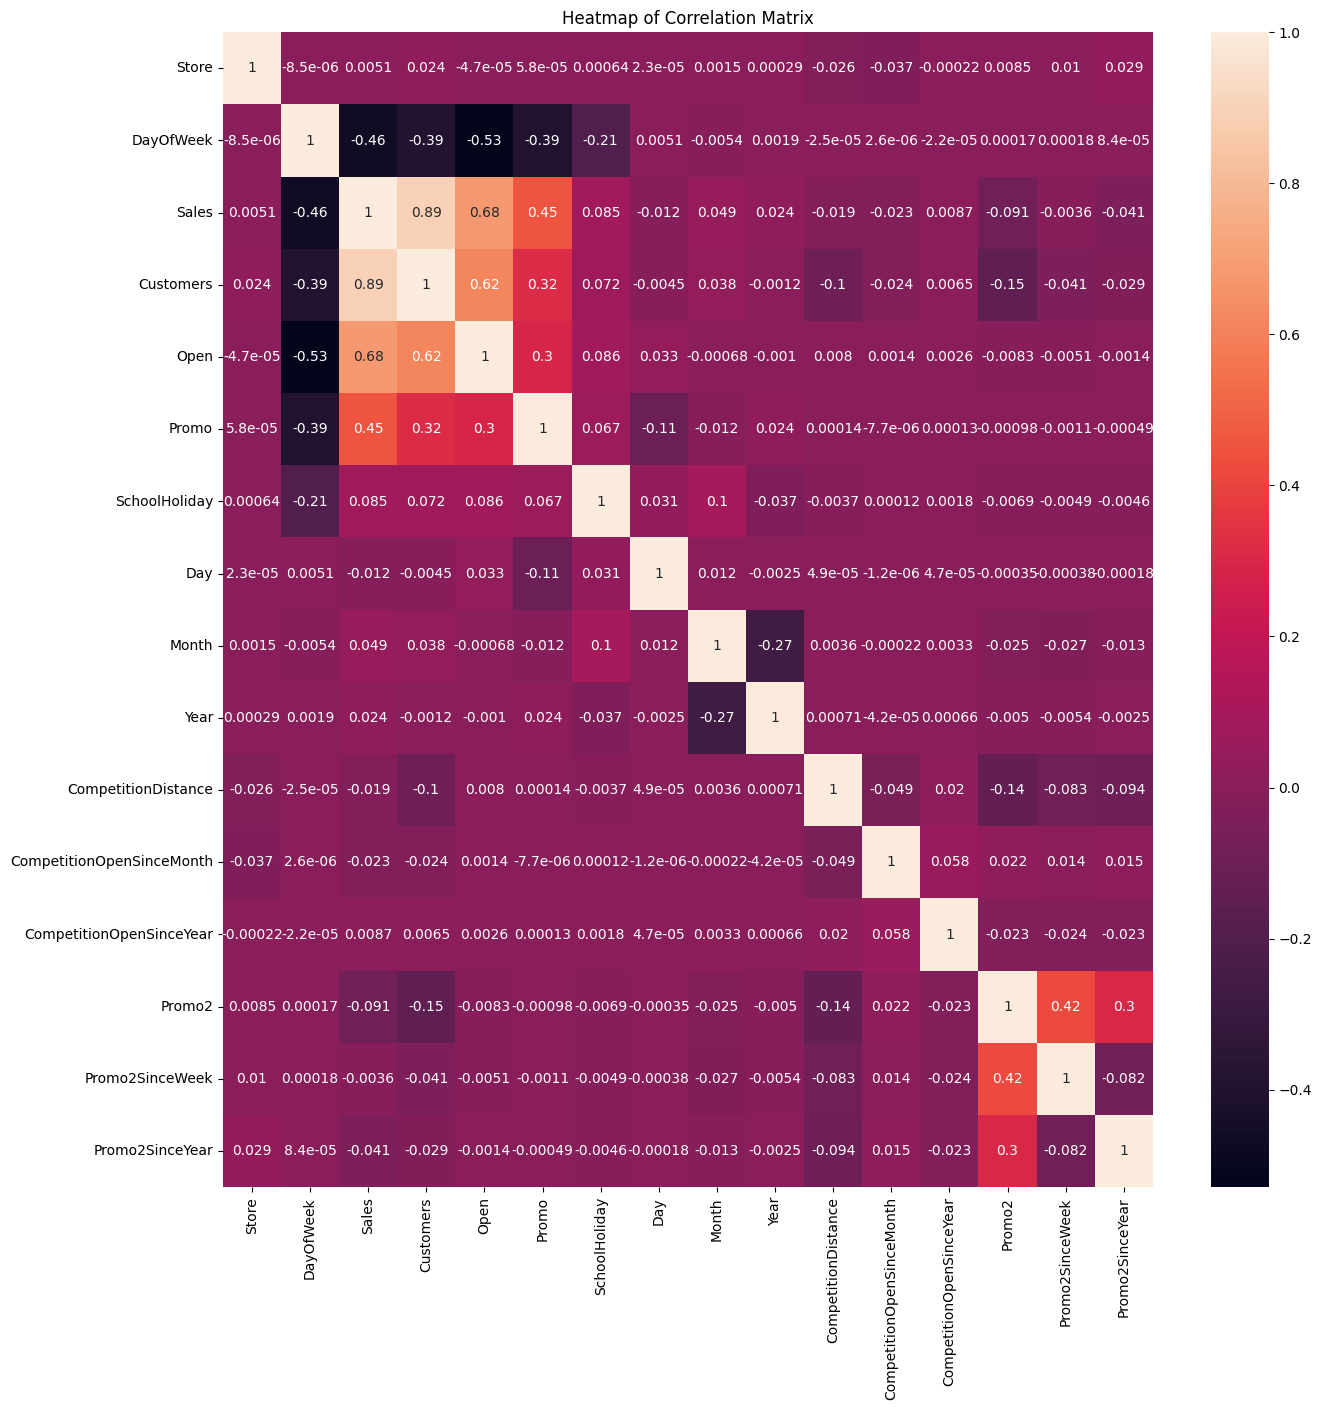

In [48]:
# Increase figure size so it would be understandable
plt.figure(figsize = (15,15))
#correlation matrix
CM=Sales[Num_Colm].corr()
sns.heatmap(CM,annot=True)
plt.title("Heatmap of Correlation Matrix")
plt.show()

# Insights
Customers,Sales,Open,Promo are high and positively correlated with each other which is understandable

Where DayOFWeek has negative correlation with this features

'Promo2', 'Promo2SinceWeek','Promo2SinceYear' has some correlation with each other

# C. Data Transformation

In [49]:
#drop where sales are 0, closed stores
Sales=Sales[Sales["Open"] !=0]
Sales=Sales.drop("Open",axis=1)

# log Transformation on comp_dist

Text(0.5, 1.0, 'Log-Transformed')

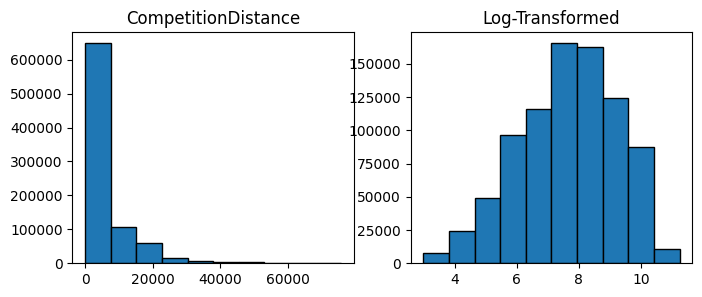

In [50]:
# (https://www.statology.org/transform-data-in-python/)


#create log-transformed data
data_log = np.log(Sales["CompetitionDistance"])

#define grid of plots
fig, axs = plt.subplots(nrows=1, ncols=2)

# histograms
axs[0].hist(Sales["CompetitionDistance"], edgecolor='black')
axs[1].hist(data_log, edgecolor='black')

#adding Title
axs[0].set_title('CompetitionDistance')
axs[1].set_title('Log-Transformed')


In [51]:
Sales["CompetitionDistance"]= np.log(Sales["CompetitionDistance"])

# SQRT trans on Customers

Text(0.5, 1.0, 'SQRT transform')

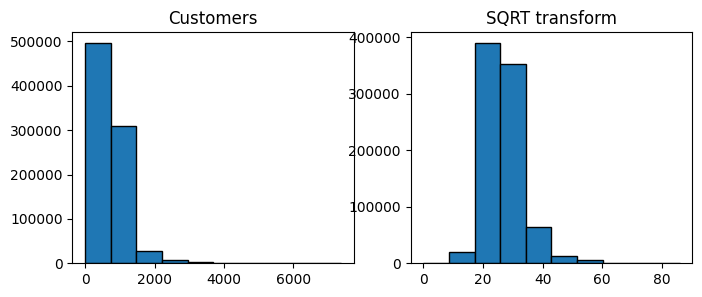

In [52]:
#create log-transformed data
data_log = np.sqrt(Sales["Customers"])

#define grid of plots
fig, axs = plt.subplots(nrows=1, ncols=2)

# histograms
axs[0].hist(Sales["Customers"], edgecolor='black')
axs[1].hist(data_log, edgecolor='black')

#adding Title
axs[0].set_title('Customers')
axs[1].set_title('SQRT transform')


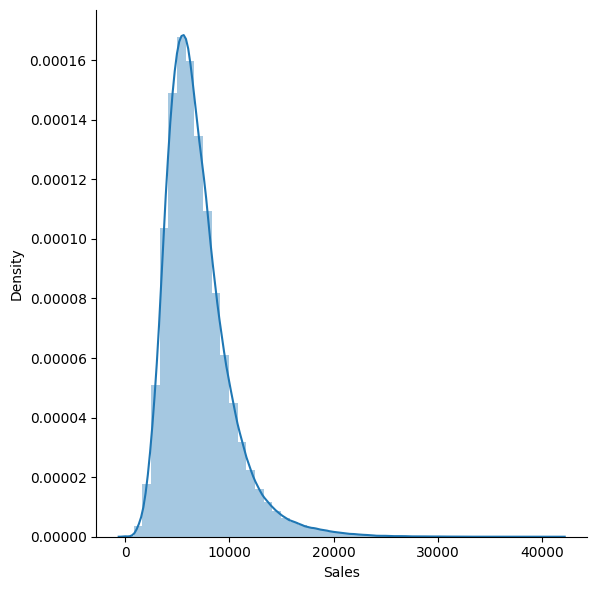

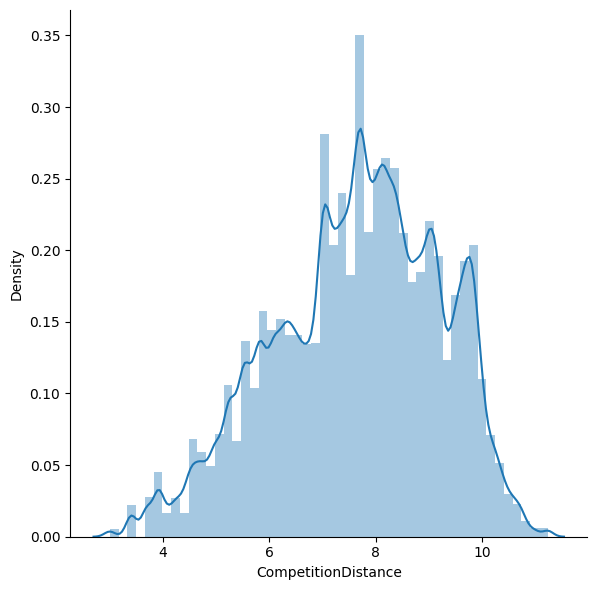

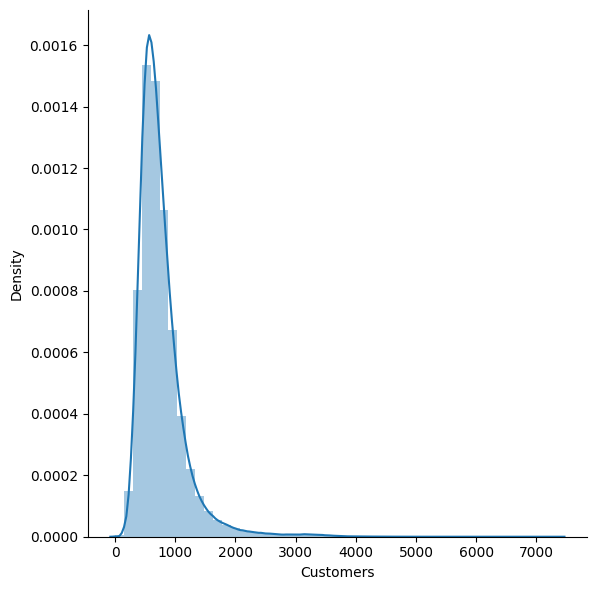

In [53]:
for i in ["Sales","CompetitionDistance",'Customers']:


  sns.FacetGrid(Sales,height=6)\
    .map(sns.distplot,i)\
    .add_legend();




In [54]:
for i in list(set(Sales.columns)-{"Store","Date","CompetitionDistance","Sales","Customers","CompetitionOpenSinceYear","Day","Promo2SinceWeek"}):
  print('\033[91m' , i , '\033[0m')
  print(Sales[i].value_counts())

 CompetitionOpenSinceMonth 
CompetitionOpenSinceMonth
9.0     364086
4.0      72256
11.0     70032
3.0      52685
7.0      49009
12.0     47887
10.0     46198
6.0      37759
5.0      32862
2.0      31360
8.0      29961
1.0      10297
Name: count, dtype: int64
 Promo2SinceYear 
Promo2SinceYear
2011.0    518347
2013.0     91866
2014.0     65768
2012.0     60716
2009.0     53826
2010.0     46414
2015.0      7455
Name: count, dtype: int64
 PromoInterval 
PromoInterval
Jan,Apr,Jul,Oct     665718
Feb,May,Aug,Nov      98005
Mar,Jun,Sept,Dec     80669
Name: count, dtype: int64
 Month 
Month
1     86343
3     85980
7     85587
6     82576
4     81731
2     80243
5     80103
8     54413
10    53292
9     52330
11    51401
12    50393
Name: count, dtype: int64
 DayOfWeek 
DayOfWeek
6    144058
2    143961
3    141936
5    138640
1    137560
4    134644
7      3593
Name: count, dtype: int64
 StoreType 
StoreType
a    457077
d    258774
c    112978
b     15563
Name: count, dtype: int64
 StateHolida

In [55]:
# Number of indivisual StateHoliday is so much less so giving them value 1 to convert them into binary features
Sales["StateHoliday"]= Sales["StateHoliday"].replace("a",1)
Sales["StateHoliday"]= Sales["StateHoliday"].replace("b",1)
Sales["StateHoliday"]= Sales["StateHoliday"].replace("c",1)
# Check
Sales["StateHoliday"].value_counts()

StateHoliday
0    843482
1       910
Name: count, dtype: int64

# MODELLING

In [56]:
# date as index
Sales.set_index(['Date'],inplace=True)
# sorting
Sales.sort_index(inplace=True)
# chekc
Sales.head(2)

,Store,DayOfWeek,Sales,Customers,Promo,StateHoliday,SchoolHoliday,Day,Month,Year,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
Date,,,,,,,,,,,,,,,,,,,
2013-01-01,1097,2,5961,1405,0,1,1,1,1,2013,b,b,6.579251,3.0,2002.0,0,14.0,2011.0,"Jan,Apr,Jul,Oct"
2013-01-01,85,2,4220,619,0,1,1,1,1,2013,b,a,7.533694,10.0,2011.0,0,14.0,2011.0,"Jan,Apr,Jul,Oct"


In [57]:
train_data=Sales.loc[:pd.to_datetime("2015-06-14")]
test_data=Sales.loc[pd.to_datetime("2015-06-15"):]

In [58]:
x_train=train_data[list(set(Sales.columns)-{"Sales","Date"})]
y_train=train_data["Sales"]

In [59]:
x_test=test_data[list(set(Sales.columns)-{"Sales","Date"})]
y_test=test_data["Sales"]

In [60]:
X=Sales[list(set(Sales.columns)-{"Sales","Date"})]
Y=Sales["Sales"]

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [66]:
Colm_OHE=['DayOfWeek', 'StoreType', 'Assortment',"PromoInterval"]

# Fitting Encoder
encoder = OneHotEncoder(sparse_output=False)
# Creating columns of OHE only based on train data because of dataleakage
encoder.fit(x_train[Colm_OHE])
features = list(encoder.get_feature_names_out(Colm_OHE))

In [67]:
# Train OHE
x_train[features] = encoder.transform(x_train[Colm_OHE])
x_train.drop(Colm_OHE,axis=1,inplace=True) # dropping Main Columns
# test
x_test[features] = encoder.transform(x_test[Colm_OHE])
x_test.drop(Colm_OHE,axis=1,inplace=True) # dropping Main Columns

# SCALING

In [68]:
scaler = StandardScaler()
X_train = scaler.fit_transform(x_train)
X_test = scaler.transform(x_test)


In [69]:
regressor = LinearRegression()
regressor.fit(X_train,y_train)

LinearRegression()

In [70]:
Ypred=regressor.predict(X_test)

In [71]:
r2 = r2_score(y_test, Ypred)
print(r2)

0.8254206279598237


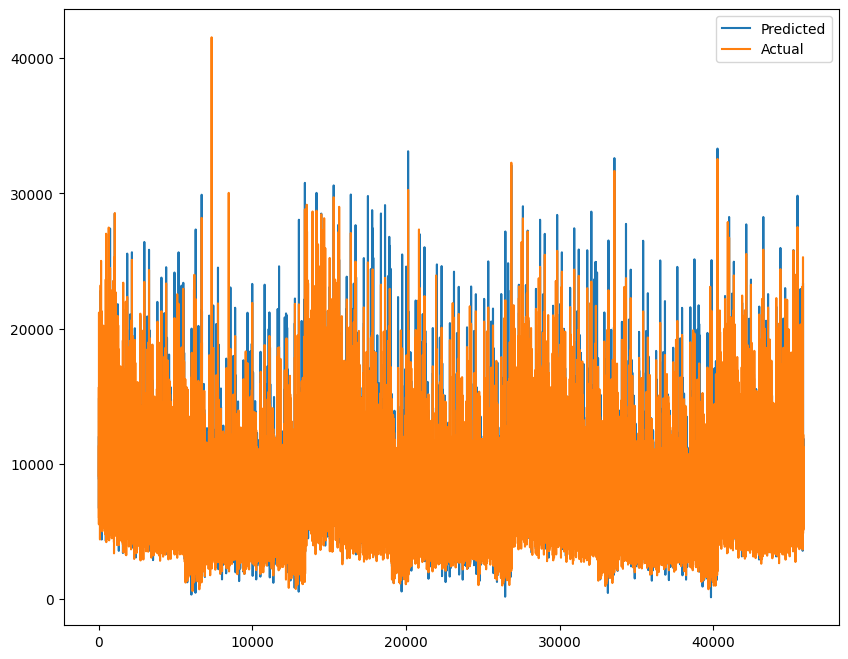

In [72]:
plt.figure(figsize=(10,8))
plt.plot(Ypred)
plt.plot(np.array(y_test))
plt.legend(["Predicted","Actual"])
plt.show()

# DECISION TREE

In [74]:
from sklearn.metrics import accuracy_score, auc
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [75]:
Decision_tree = DecisionTreeRegressor()
Decision_tree_reg = Decision_tree.fit(X_train, y_train)
#predict the X_train and X-test values
y_pred_train_d = Decision_tree.predict(X_train)
y_pred_test_d = Decision_tree.predict(X_test)

r2_train_decision = r2_score(y_train, y_pred_train_d)
print(r2_train_decision)

r2_test_decision= r2_score(y_test, y_pred_test_d)
print(r2_test_decision)

1.0
0.9452700046489497


# RANDOM FOREST

In [76]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score,roc_auc_score,confusion_matrix

In [77]:
rdf = RandomForestRegressor(n_estimators=80,min_samples_split=2, min_samples_leaf=1,max_depth=None,n_jobs=-1)
rdfreg = rdf.fit(X_train, y_train)

y_pred_train_r = rdf.predict(X_train)
y_pred_test_r = rdf.predict(X_test)

r2_train_random = r2_score(y_train, y_pred_train_r)
print(r2_train_random)

r2_test_random= r2_score(y_test, y_pred_test_r)
print(r2_test_random)

0.9967241535451623
0.9651684726756183


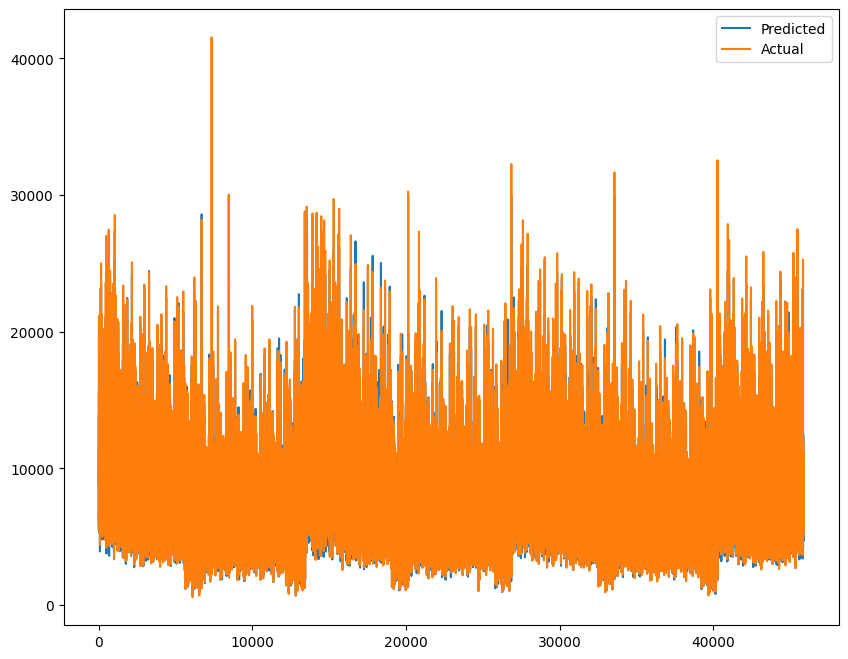

In [78]:
plt.figure(figsize=(10,8))
plt.plot(y_pred_test_r)
plt.plot(np.array(y_test))
plt.legend(["Predicted","Actual"])
plt.show()

Mean Absolute Error (MAE): 387.74
Mean Squared Error (MSE): 332393.78
Root Mean Squared Error (RMSE): 576.54
R² Score: 0.97


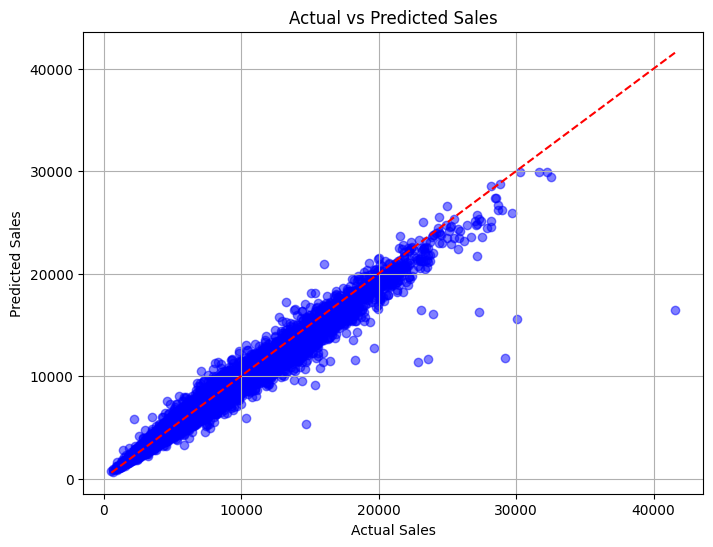

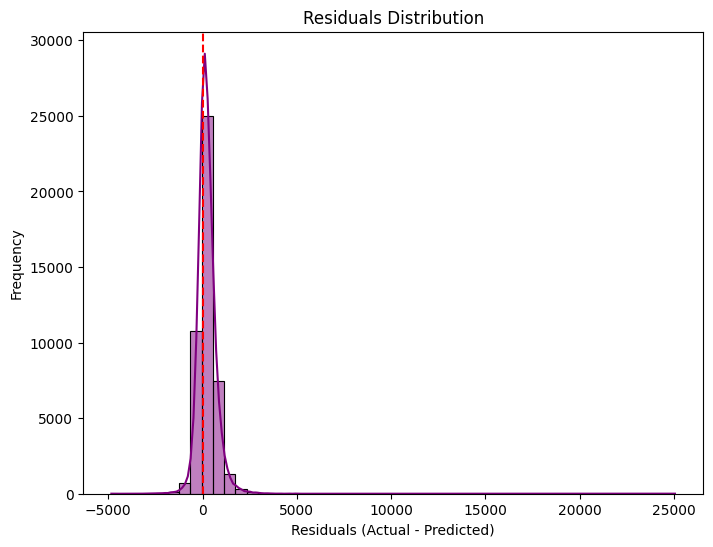

In [80]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Predict values
y_pred = rdf.predict(X_test)

# Calculate regression metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# Residuals Plot (Actual vs Predicted)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle="--")  # 45-degree line
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual vs Predicted Sales")
plt.grid(True)
plt.show()

# Residual Distribution Plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=50, kde=True, color='purple')
plt.axvline(0, color='red', linestyle='--')  # Reference line at zero
plt.title("Residuals Distribution")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.show()


# Conclusion
1. Rossmann Stores Data.csv dataset has 10,107,219 rows and 10 columns. store.csv dataset has 1115 rows and 9 columns.
2. The sales in the month of December is the highest sales among others.
3. The Promotion increases the sales so we should focus on that factor
4. As the customers are positively correlated with sales so we have to increase the frequecy of customers by offers
5. The sales for store type B is higher than any other stores